This is an implementation of a random forest model working on a dataset containing info about cars. we will be attempting to classify
 Price Range for Chevrolet.

Steps:
1. Clean the dataset
2. Remove Outliers
3. Split the dataset
4. Train the model and evaluate.
5. See prediction and visualise the model

To start, we import the libraries necessary:

In [1]:
import pandas as panda
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')


The data is loaded:

In [2]:
car_data = panda.read_csv("data/ALL_CARS_DATA.csv")

We only want to look at the brand , to simplify the model, we drop all rows which are not Chevrolet

In [3]:
chevy = car_data[car_data['BRAND'] == 'Chevrolet']
print('Rows before cleaning', len(chevy))
chevy = chevy.dropna()
print('Rows after cleaning', len(chevy))

Rows before cleaning 26689
Rows after cleaning 26647


 For this prediction we isolate price range. We selected the features of car type, make origin, mileage and age of car.

In [5]:
X = chevy[['CAR TYPE', 'MAKE ORIGIN', 'MILEAGE', 'AGE OF CAR']]
Y = chevy['PRICE RANGE']

We then turn text categories (like car type, price range) into numbers to avoid working with text inputs.

In [7]:
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le

    le_target = LabelEncoder()
    Y_encoded = le_target.fit_transform(Y)

We then split data into a training set and a testing set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded
)

The data is then scaled to be within similar ranges to allow for better visualisation.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building a Random Forest model with specific settings and training it with our training
 subset.

In [10]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
)

rf_classifier.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


We use the trained model to make predictions, then we measure how accurate those predictions are.

In [12]:
y_pred = rf_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

Accuracy: 0.6037523452157598

Classification Report:
              precision    recall  f1-score   support

        High       0.39      0.48      0.43      1193
         Low       0.81      0.73      0.77      1442
      Luxury       0.61      0.58      0.59      1175
      Medium       0.63      0.60      0.61      1520

    accuracy                           0.60      5330
   macro avg       0.61      0.60      0.60      5330
weighted avg       0.62      0.60      0.61      5330



Creating a visual chart that shows exactly where the model made correct and incorrect predictions.

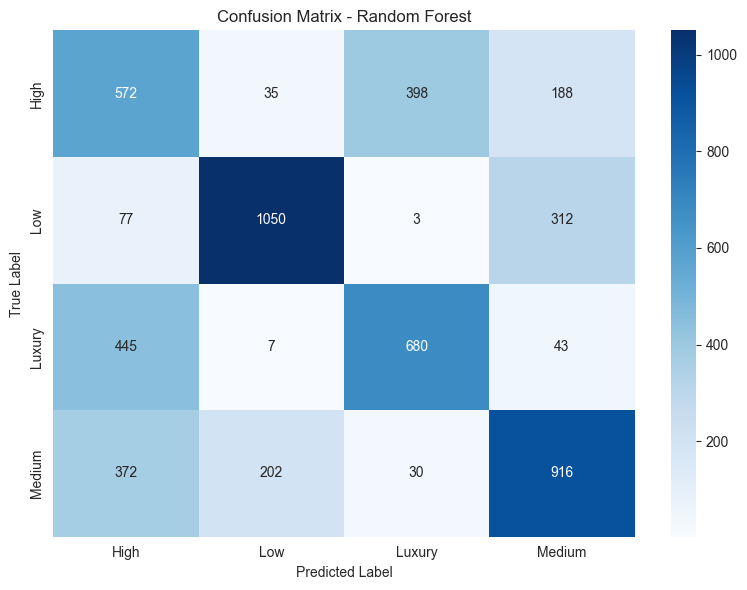

In [13]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Then we out which car features (mileage, age, etc.) were most important for predicting price range.

In [14]:
feature_importance = panda.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
       feature  importance
2      MILEAGE    0.453343
3   AGE OF CAR    0.290011
0     CAR TYPE    0.244001
1  MAKE ORIGIN    0.012645


Our result was that make origin was not a relevant feature.

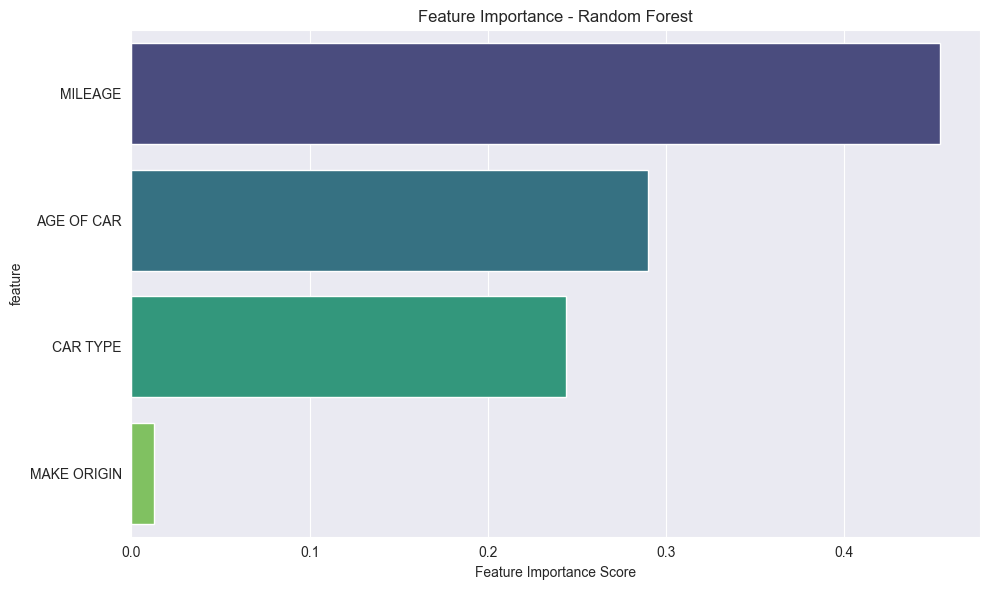

In [16]:

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

We compare accuracy between training data vs testing data to make sure the model learned patterns instead of just memorizing (check for under/overfitting).

In [17]:
train_accuracy = accuracy_score(y_train, rf_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6323
Testing Accuracy: 0.6038


Finally, we save the trained model and additional processing tools to be used again, without retraining.

In [18]:
import joblib

model_data = {
    'model': rf_classifier,
    'label_encoders': label_encoders,
    'target_encoder': le_target,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}

joblib.dump(model_data, 'random_forest_chevrolet_price_predictor.pkl')
print("Model saved successfully")

Model saved successfully
